In [ ]:
# default_exp examples.multilabel_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# examples.multilabel_classification

> This is an example of how to use blurr for multilabel classification tasks

In [ ]:
#export
import torch, datasets
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.5
Using transformers 4.2.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


Let's start by building our `DataBlock`

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = datasets.load_dataset('civil_comments', split='train[:1%]') 
len(raw_data)

Using custom data configuration default
Reusing dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/98bdc73fc77a117cf5d17c9977e278c8023c64177a3ed9e0c49f7a5bdf10a47b)


18049

In [ ]:
toxic_df = pd.DataFrame(raw_data, columns=list(raw_data.features.keys()))
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
task = HF_TASKS_ALL.SequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

In [ ]:
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=16)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([16, 391]), torch.Size([16, 6]))

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 16 x 404)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 404 x 768      
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
     

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([16, 6]),
 SequenceClassifierOutput(loss=None, logits=tensor([[-0.0359,  0.1567, -0.0386, -0.1270,  0.1894,  0.0810],
         [-0.0206,  0.1723, -0.0500, -0.1536,  0.1946,  0.0834],
         [-0.0265,  0.1759, -0.0549, -0.1345,  0.1890,  0.0767],
         [-0.0107,  0.1586, -0.0421, -0.1372,  0.1863,  0.0644],
         [-0.0229,  0.1689, -0.0440, -0.1581,  0.1804,  0.0933],
         [-0.0376,  0.1635, -0.0403, -0.1526,  0.1958,  0.0842],
         [-0.0276,  0.1663, -0.0558, -0.1267,  0.1580,  0.0632],
         [-0.0239,  0.1686, -0.0549, -0.1663,  0.1933,  0.0588],
         [-0.0105,  0.1576, -0.0471, -0.1462,  0.1720,  0.0672],
         [-0.0303,  0.1748, -0.0260, -0.1388,  0.1991,  0.0796],
         [-0.0269,  0.1686, -0.0507, -0.1421,  0.1883,  0.0758],
         [-0.0137,  0.1868, -0.0516, -0.1664,  0.2046,  0.0925],
         [-0.0238,  0.1676, -0.0447, -0.1329,  0.1822,  0.0613],
         [-0.0233,  0.1626, -0.0430, -0.1382,  0.1908,  0.0759],
         [-0.0203,  0.168

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.5248074531555176)

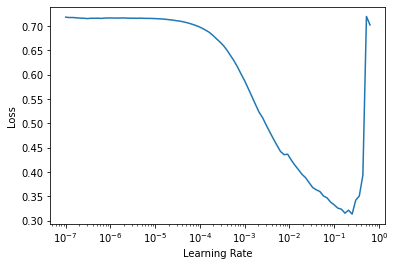

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.037468,0.035613,0.993211,01:05


SuggestedLRs(lr_min=5.011872427490572e-13, lr_steep=9.54992595419979e-12)

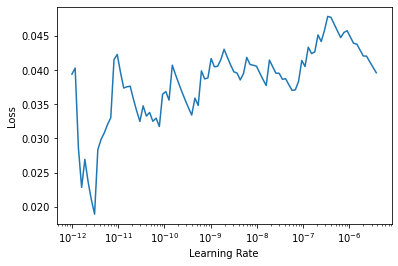

In [ ]:
learn.unfreeze()
learn.lr_find(suggestions=True, start_lr=1e-12, end_lr=1e-5)

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(1e-10, 4e-9))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.031932,0.035613,0.993211,01:42
1,0.043727,0.035613,0.993211,01:43


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"While I can't speak to the factual accuracy in this article (hotly debated in the comments) I can say that it was sloppy and amateurish. \n\nThe main headline has absolutely nothing to so with the sub-header and the following article is not much better as far as relevance to the headline (why is the cost of the school your opening line?)\n\nThe word ""parents"" is used repeatedly like there is rampant uproar, but there is exactly one sentence from one parent expressing dissatisfaction. \n\nThere is zero concern for the side of the ninth-grader, his treatment, or his family, which represents a significant part of this story. The level of one-sidedness is quite off-putting. It sounds like something someone would write on Facebook where their own strong personal bias is expected to show. \n\nThis is a newspaper. One that I can usually count on to report the news. I'm not sure how an article this poorly executed and thoroughly incomplete wasn't critiqued before being edited and published. Do better.",,[]
1,"May I say it slowly. Criticism.........of.........someone's.........actions...........is..........not......ipso.........facto........a........\n..manifestation..........of........bias. in......my.......opinion,.........Coach.......K's.......comments.....were......unnecessary........and...\n....unprofessional. I.......would........say.........the......same........thing........about.......any......coach......who......took......such....action...... \n\nHere's a parallel which might help. If I, as a teacher, witnessed inappropriate behavior in the classroom of another teacher, I would not chastize the student. I would mention the behavior to the other teacher in private and let them address or not address the issue. That's called common courtesy and professionalism. Surely, that's not too tough a concept to understand. \n\nIn my opinion, and, as his his comments in the press conference seemed to confirm, Coach K was angered by the loss and ""took it out"" on Brooks. A bad show......",,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

[(((#1) ['insult'],),
  (#1) [tensor([False, False, False,  True, False, False])],
  (#1) [tensor([1.0088e-07, 3.2225e-03, 3.1693e-05, 3.1980e-02, 8.3283e-04, 2.4729e-04])])]

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
